# Baseline Model: Affective Feature-Based Stress Detection

This notebook implements an interpretable baseline for stress detection using affective, linguistic, and readability features derived from social media posts.

## 1. Introduction

The goal of this notebook is to establish a simple and interpretable baseline for stress classification.  
Based on the exploratory data analysis, I focus on affective and linguistic features rather than surface-level statistics.


In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score


RANDOM_STATE = 42


## 2. Data Loading

I load the Dreaddit dataset and prepare the feature matrix and target variable for modeling.


In [3]:
import kagglehub

path = kagglehub.dataset_download("monishakant/dataset-for-stress-analysis-in-social-media")
csv_path = os.path.join(path, "dreaddit_StressAnalysis - Sheet1.csv")

df = pd.read_csv(csv_path)
df.head()


,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1514980773,22,-1.238793,...,1.0000,1.2000,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1493348050,5,7.684583,...,1.4000,1.1250,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909
2,7977,ptsd,8eeu1t,"(5, 10)",We'd be saving so much money with this new hou...,1,1.0,1524516630,10,2.360408,...,1.1429,1.0000,1.0,1.70974,1.52985,1.86108,1.00,8,3.149288,-0.036818
3,1214,ptsd,8d28vu,"[2, 7]","My ex used to shoot back with ""Do you want me ...",1,0.5,1524018289,5,5.997000,...,1.0000,1.3000,1.0,1.72615,1.52000,1.84909,1.00,7,6.606000,-0.066667
4,1965,relationships,7r1e85,"[23, 28]",I haven’t said anything to him yet because I’m...,0,0.8,1516200171,138,4.649418,...,1.1250,1.1429,1.0,1.75642,1.43582,1.91725,0.84,70,4.801869,0.141667


## 3. Feature Selection

Based on the exploratory data analysis, I select a compact set of affective, linguistic, and readability features to build an interpretable baseline model.

The selected features are designed to capture complementary aspects of stress expression:
- affective polarity and emotional tone (sentiment, DAL features),
- self-focus and emotional categories (LIWC),
- stylistic and structural properties of the text (readability metrics).

Rather than using the full set of available psycholinguistic features, I intentionally restrict the feature space to reduce redundancy, improve interpretability, and avoid overfitting given the relatively small dataset size. This choice allows for clearer analysis of feature contributions while providing a strong baseline for comparison with more expressive models.


In [4]:
FEATURES = [
    # Readability / style
    "syntax_ari",
    "syntax_fk_grade",
    "lex_liwc_WC",              
    "lex_liwc_Authentic",      
    "lex_liwc_Tone",            

    # Affective (DAL and sentiment)
    "lex_dal_avg_pleasantness",
    "lex_dal_avg_activation",
    "lex_dal_avg_imagery",
    "sentiment",

    # LIWC 
    "lex_liwc_i",
    "lex_liwc_negemo",
    "lex_liwc_anx",
    "lex_liwc_sad",
    "lex_liwc_negate",
    "lex_liwc_social",
]
TARGET = "label"


In [5]:
# Check for missing values

missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
missing


[]

In [6]:
# Train/Test split

X = df[FEATURES]
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape


((572, 15), (143, 15))

## Model and Pipeline Design

To establish a transparent and reproducible baseline, I implement a simple modeling pipeline composed of three main steps: imputation, feature scaling, and classification.

Missing values are handled using median imputation, which is robust to outliers and suitable for numeric psycholinguistic features. Feature scaling is applied to ensure that all inputs are on a comparable scale, allowing model coefficients to be meaningfully interpreted.

For classification, I use logistic regression as a linear and interpretable model. This choice enables direct inspection of feature coefficients, facilitating qualitative analysis of which linguistic and affective signals contribute most to stress predictions. While simple, this approach provides a strong and explainable baseline against which more complex models can later be evaluated.


In [7]:
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

pipe.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. I

## 5. Evaluation

Model performance is evaluated on a held-out test set using precision, recall, and F1-score.


              precision    recall  f1-score   support

           0      0.732     0.754     0.743        69
           1      0.764     0.743     0.753        74

    accuracy                          0.748       143
   macro avg      0.748     0.748     0.748       143
weighted avg      0.749     0.748     0.748       143



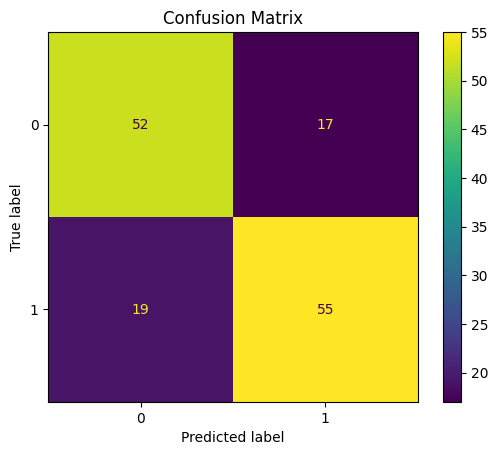

In [24]:
y_pred = pipe.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title("Confusion Matrix")
plt.show()


In addition to precision, recall and F1-score, I evaluate the model using ROC-AUC. This metric provides a threshold-independent assessment of the model’s ability to discriminate between stress and non-stress posts.

ROC-AUC: 0.8143


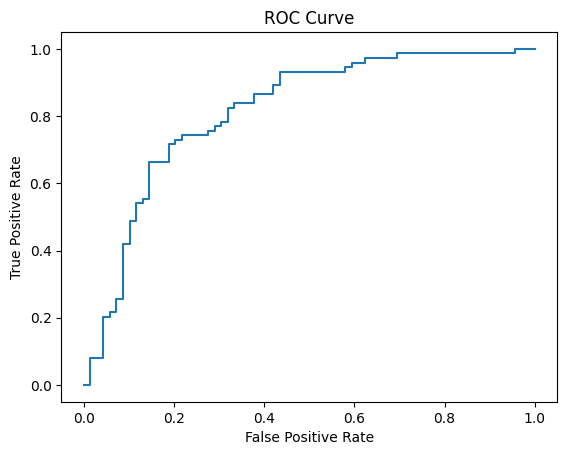

In [ ]:
y_proba = pipe.predict_proba(X_test)[:, 1] # I take only stress probabilities from the matrix [n_samples,2]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


Since stress detection can involve class imbalance, I also inspect the Precision-Recall curve, which is more informative when evaluating performance on the positive class.

Average Precision: 0.7690


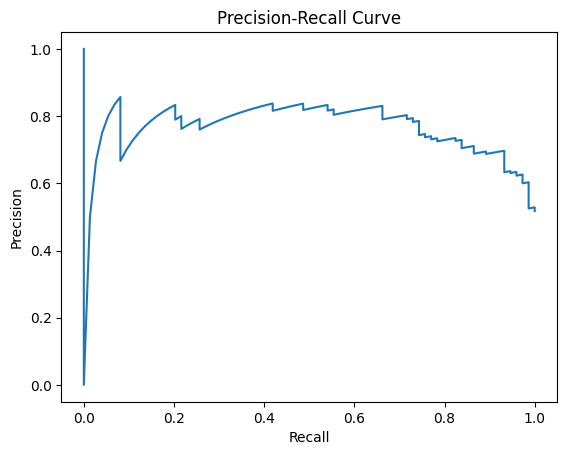

In [32]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

print(f"Average Precision: {ap:.4f}")

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


The ROC-AUC of 0.81 indicates good separability between stress and non-stress posts. However, since stress detection focuses on correctly identifying the positive class, the Precision-Recall curve provides more practical insight. The average precision score of 0.77 confirms stable performance across different recall levels.

Instead of using the default decision threshold of 0.5, I optimize the classification threshold to maximize macro F1-score. This is particularly important in stress detection, where false negatives may carry higher practical risk.

In [34]:
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh, average="macro"))

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print("Best threshold:", best_threshold)
print("Best macro F1:", best_f1)


Best threshold: 0.5408163265306123
Best macro F1: 0.762133072407045


The optimal decision threshold is slightly above 0.5 (≈0.54), suggesting that the default threshold is already close to optimal. The modest improvement in macro F1 indicates that the logistic regression model produces reasonably calibrated probability estimates.

## 6. Interpretation

I analyze model coefficients to identify which features contribute most to stress predictions.


In [9]:
clf = pipe.named_steps["clf"]
coefs = clf.coef_[0]

coef_df = pd.DataFrame({
    "feature": FEATURES,
    "coefficient": coefs
}).sort_values("coefficient", ascending=False)

coef_df


,feature,coefficient
9,lex_liwc_i,0.614177
2,lex_liwc_WC,0.489971
10,lex_liwc_negemo,0.451971
11,lex_liwc_anx,0.368407
7,lex_dal_avg_imagery,0.208697
13,lex_liwc_negate,0.193093
6,lex_dal_avg_activation,0.051817
12,lex_liwc_sad,0.019655
3,lex_liwc_Authentic,-0.036775
1,syntax_fk_grade,-0.071196


In [10]:
# Save baseline coefficients 

os.makedirs("results", exist_ok=True)
coef_df.to_csv("results/baseline_logreg_coefficients.csv", index=False)


In [11]:
# Save baseline metrics 

from sklearn.metrics import precision_recall_fscore_support

p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
with open("results/baseline_metrics.txt", "w") as f:
    f.write(f"Precision: {p:.4f}\n")
    f.write(f"Recall:    {r:.4f}\n")
    f.write(f"F1:        {f1:.4f}\n")
print(p, r, f1)


0.7638888888888888 0.7432432432432432 0.7534246575342466


The analysis of the logistic regression coefficients highlights clear and interpretable patterns in stress-related language.

The strongest positive contributors to stress predictions are first-person singular pronouns (`lex_liwc_i`), text length (`lex_liwc_WC`), and negative emotional language (`lex_liwc_negemo`, `lex_liwc_anx`). This suggests that stress-related posts tend to be self-focused, emotionally negative, and often longer, consistent with patterns of emotional disclosure and rumination.

Interestingly, higher imagery scores (`lex_dal_avg_imagery`) also contribute positively, indicating that stress-related posts frequently include concrete, detailed narratives of personal experiences.

Conversely, features associated with positive emotional tone (`lex_liwc_Tone`, `lex_dal_avg_pleasantness`, `sentiment`), social references (`lex_liwc_social`), and higher readability (`syntax_ari`, `syntax_fk_grade`) are negatively associated with stress. This suggests that non-stress posts tend to be more positive, socially oriented, and linguistically structured.

Overall, these results confirm that affective and psycholinguistic features capture meaningful signals of stress expression, while remaining interpretable and consistent with the exploratory analysis.


## 7. Error Analysis

In this section, I analyze the model’s errors to better understand its limitations and failure modes. 
Rather than focusing only on aggregate metrics, I inspect misclassified examples to identify recurring patterns and potential sources of confusion.

This analysis helps assess whether errors stem from limitations of the selected features, from ambiguity in the language, or from inherently difficult cases where stress signals are subtle or mixed.


In [12]:
proba = pipe.predict_proba(X_test)[:, 1]
err = X_test.copy()
err["y_true"] = y_test.values
err["y_pred"] = y_pred
err["p_stress"] = proba

wrong = err[err["y_true"] != err["y_pred"]].copy()
wrong.sort_values("p_stress", ascending=False).head(10)


,syntax_ari,syntax_fk_grade,lex_liwc_WC,lex_liwc_Authentic,lex_liwc_Tone,lex_dal_avg_pleasantness,lex_dal_avg_activation,lex_dal_avg_imagery,sentiment,lex_liwc_i,lex_liwc_negemo,lex_liwc_anx,lex_liwc_sad,lex_liwc_negate,lex_liwc_social,y_true,y_pred,p_stress
633,5.197728,6.005504,120,99.00,1.00,1.79051,1.77267,1.67850,-0.304444,15.00,10.83,0.83,0.00,3.33,10.83,0,1,0.981820
604,5.939605,6.330105,76,99.00,1.00,1.87565,1.76824,1.56418,-0.053030,17.11,5.26,3.95,0.00,3.95,6.58,0,1,0.941977
526,2.310545,2.001818,55,66.98,5.95,1.92030,1.83865,1.87556,-0.220000,20.00,7.27,0.00,0.00,0.00,12.73,0,1,0.940310
197,0.036250,2.607778,70,99.00,1.00,1.84680,1.74814,1.56667,0.033766,12.86,4.29,1.43,2.86,1.43,5.71,0,1,0.885865
651,4.576338,5.404338,69,72.78,1.00,1.76654,1.71661,1.55484,-0.290556,10.14,8.70,0.00,2.90,1.45,5.80,0,1,0.872949
426,-0.713824,0.944353,31,20.84,1.00,1.83055,1.70227,1.69231,-0.200000,9.68,6.45,0.00,3.23,6.45,16.13,0,1,0.854661
216,5.350219,5.978279,59,99.00,1.00,1.81911,1.76238,1.63556,0.035417,11.86,6.78,0.00,0.00,0.00,5.08,0,1,0.768590
256,7.996786,8.100095,84,80.64,1.00,1.84893,1.73923,1.56364,-0.057143,11.90,7.14,1.19,3.57,0.00,14.29,0,1,0.745180
635,4.877838,6.188964,107,93.11,13.19,1.85443,1.70649,1.57802,-0.073810,10.28,0.93,0.93,0.00,0.93,2.80,0,1,0.681614
148,8.634871,9.784386,184,86.86,66.89,1.92767,1.78623,1.39515,0.142544,12.50,3.80,1.63,0.54,2.17,8.15,0,1,0.668159


Inspection of high-confidence misclassifications reveals consistent and interpretable error patterns.

Most false positives correspond to non-stress posts characterized by strong self-focus, high authenticity, and emotionally expressive language. These posts often resemble stress-related narratives in terms of style and affect, despite not being labeled as stress.

This suggests that the baseline model tends to conflate emotionally rich or personal storytelling with stress, highlighting the limitations of feature-based approaches in capturing nuanced semantic distinctions. Such cases motivate the use of models that can better account for context and meaning beyond surface-level affective signals.


## 8. Summary

In this notebook, I implemented an interpretable baseline for stress detection using affective, psycholinguistic, and readability features.

Robust evaluation through cross-validation and threshold tuning confirms that the baseline performance is stable and not dependent on a single data split. The ROC and Precision-Recall analysis further show that the model maintains consistent discrimination ability across different decision thresholds.

The results show that stress-related language is strongly associated with self-focused expression, negative emotional content, and longer, narrative-style posts. At the same time, features related to positive emotional tone, social references, and higher readability are negatively associated with stress.

Error analysis reveals that most misclassifications occur in emotionally expressive but non-stress posts, highlighting the limitations of feature-based approaches in capturing nuanced semantic distinctions. Overall, this baseline confirms the relevance of affective signals while motivating the use of more expressive semantic models in subsequent experiments.


